<a href="https://colab.research.google.com/github/sochoav1/MachineLearningHidrogenAtom/blob/main/MachineLearningHidrogenAtom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

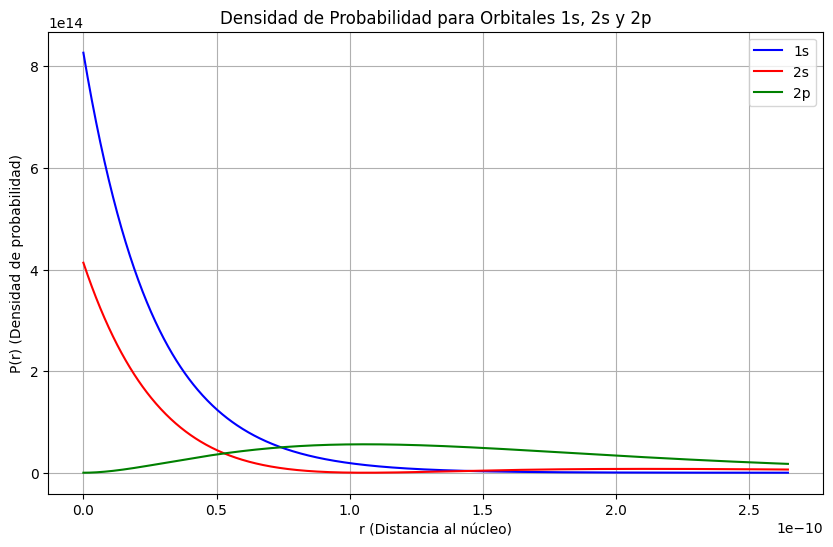

In [23]:
# Importando las bibliotecas necesarias
import numpy as np
import tensorflow as tf
from scipy.special import genlaguerre
from scipy.constants import physical_constants
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Generar datos para la función de onda radial del átomo de hidrógeno
a_0 = physical_constants["Bohr radius"][0]  # Radio de Bohr
n = 1
l = 0
# Funciones de onda radiales para los orbitales 1s, 2s y 2p
def R_1s(r):
    coeff = (1 / np.sqrt(np.pi)) * np.sqrt(1 / a_0)**(3/2)
    return coeff * np.exp(-r / a_0)

def R_2s(r):
    coeff = (1 / (2 * np.sqrt(2 * np.pi))) * np.sqrt(1 / a_0)**(3/2)
    return coeff * ((2 - r/a_0) * np.exp(-r / (2 * a_0)))

def R_2p(r):
    coeff = (1 / (2 * np.sqrt(2 * np.pi))) * np.sqrt(1 / a_0)**(3/2)
    return coeff * (r / a_0) * np.exp(-r / (2 * a_0))

# Generar datos
r_values = np.linspace(0, 5 * a_0, 1000)
P_1s_values = R_1s(r_values)**2
P_2s_values = R_2s(r_values)**2
P_2p_values = R_2p(r_values)**2

plt.figure(figsize=(10, 6))
plt.plot(r_values, P_1s_values, label="1s", color="blue")
plt.plot(r_values, P_2s_values, label="2s", color="red")
plt.plot(r_values, P_2p_values, label="2p", color="green")
plt.xlabel("r (Distancia al núcleo)")
plt.ylabel("P(r) (Densidad de probabilidad)")
plt.title("Densidad de Probabilidad para Orbitales 1s, 2s y 2p")
plt.legend()
plt.grid(True)
plt.show()


In [24]:
# Dividir los datos en conjuntos de entrenamiento y prueba
r_train, r_test, P_1s_train, P_1s_test = train_test_split(r_values, P_1s_values, test_size=0.2, random_state=42)

# Escalar los datos
scaler_r = MinMaxScaler().fit(r_train.reshape(-1, 1))
scaler_P_1s = MinMaxScaler().fit(P_1s_train.reshape(-1, 1))

r_train_scaled = scaler_r.transform(r_train.reshape(-1, 1))
r_test_scaled = scaler_r.transform(r_test.reshape(-1, 1))
P_1s_train_scaled = scaler_P_1s.transform(P_1s_train.reshape(-1, 1))
P_1s_test_scaled = scaler_P_1s.transform(P_1s_test.reshape(-1, 1))

r_train_scaled.shape, r_test_scaled.shape, P_1s_train_scaled.shape, P_1s_test_scaled.shape


((800, 1), (200, 1), (800, 1), (200, 1))

In [25]:
model_P_1s = keras.Sequential([
    layers.Dense(256, activation='relu', input_shape=(1,)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

optimizer = keras.optimizers.Adam(learning_rate=0.001)
model_P_1s.compile(optimizer=optimizer, loss='mse')

history_P_1s = model_P_1s.fit(r_train_scaled, P_1s_train_scaled, epochs=700, validation_data=(r_test_scaled, P_1s_test_scaled), verbose=0)


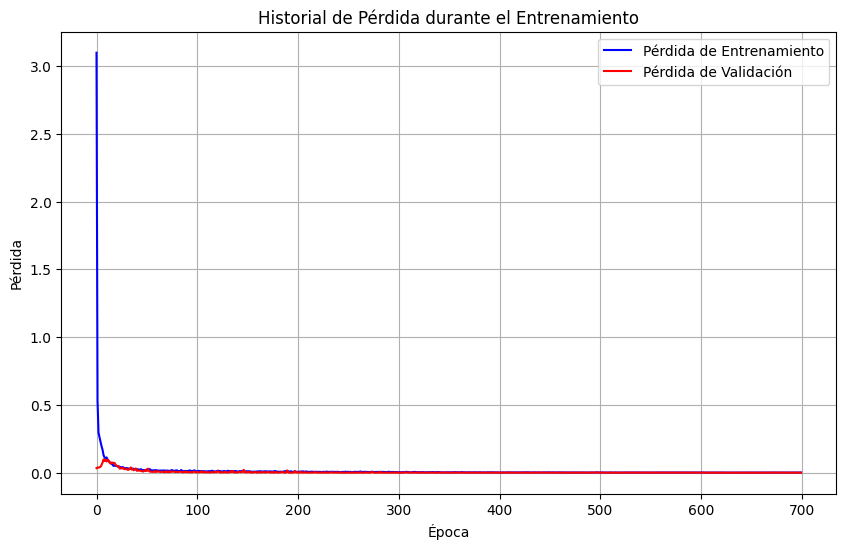

In [26]:
# Graficar la pérdida durante el entrenamiento y la validación
plt.figure(figsize=(10, 6))
plt.plot(history_P_1s.history['loss'], label='Pérdida de Entrenamiento', color='blue')
plt.plot(history_P_1s.history['val_loss'], label='Pérdida de Validación', color='red')
plt.title('Historial de Pérdida durante el Entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)
plt.show()


32/32 [==============================] - 0s 2ms/step


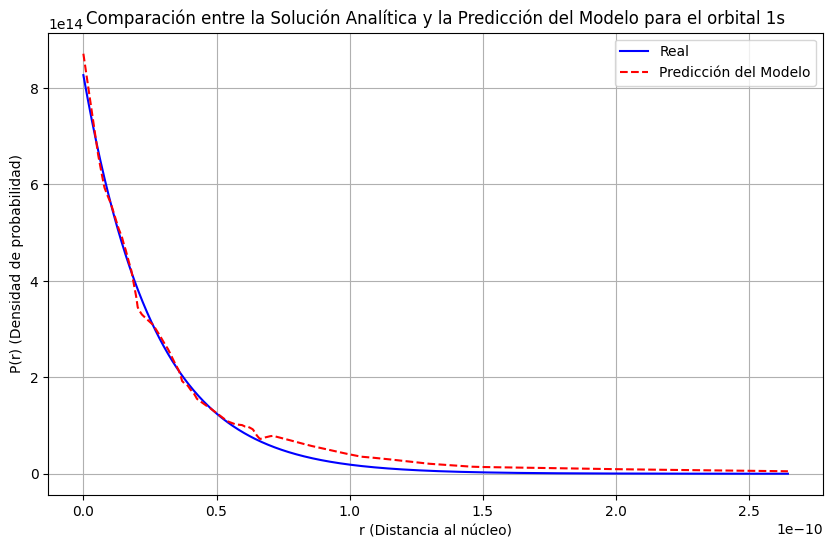

In [27]:
# 1. Hacer predicciones con el modelo en todo el rango de valores de r
P_1s_pred_scaled = model_P_1s.predict(scaler_r.transform(r_values.reshape(-1, 1)))

# 2. Transformar las predicciones escaladas de vuelta a su escala original
P_1s_pred = scaler_P_1s.inverse_transform(P_1s_pred_scaled)

# 3. Graficar las predicciones y los valores reales
plt.figure(figsize=(10, 6))
plt.plot(r_values, P_1s_values, label="Real", color="blue")
plt.plot(r_values, P_1s_pred, label="Predicción del Modelo", linestyle='--', color="red")
plt.xlabel("r (Distancia al núcleo)")
plt.ylabel("P(r) (Densidad de probabilidad)")
plt.title("Comparación entre la Solución Analítica y la Predicción del Modelo para el orbital 1s")
plt.legend()
plt.grid(True)
plt.show()


In [28]:
# 1. Dividir los datos de los orbitales 2s y 2p en conjuntos de entrenamiento y prueba
_, _, P_2s_train, P_2s_test = train_test_split(r_values, P_2s_values, test_size=0.2, random_state=42)
_, _, P_2p_train, P_2p_test = train_test_split(r_values, P_2p_values, test_size=0.2, random_state=42)

# 2. Escalar estos datos
scaler_P_2s = MinMaxScaler().fit(P_2s_train.reshape(-1, 1))
scaler_P_2p = MinMaxScaler().fit(P_2p_train.reshape(-1, 1))

P_2s_train_scaled = scaler_P_2s.transform(P_2s_train.reshape(-1, 1))
P_2s_test_scaled = scaler_P_2s.transform(P_2s_test.reshape(-1, 1))

P_2p_train_scaled = scaler_P_2p.transform(P_2p_train.reshape(-1, 1))
P_2p_test_scaled = scaler_P_2p.transform(P_2p_test.reshape(-1, 1))

# 3. Entrenar un modelo de red neuronal para cada uno de estos orbitales

# Modelo para 2s
model_P_2s = keras.Sequential([
    layers.Dense(256, activation='relu', input_shape=(1,)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

model_P_2s.compile(optimizer='adam', loss='mse')
history_P_2s = model_P_2s.fit(r_train_scaled, P_2s_train_scaled, epochs=500, validation_data=(r_test_scaled, P_2s_test_scaled), verbose=0)

# Modelo para 2p
model_P_2p = keras.Sequential([
    layers.Dense(256, activation='relu', input_shape=(1,)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

model_P_2p.compile(optimizer='adam', loss='mse')
history_P_2p = model_P_2p.fit(r_train_scaled, P_2p_train_scaled, epochs=500, validation_data=(r_test_scaled, P_2p_test_scaled), verbose=0)

# 4. Evaluar el rendimiento de estos modelos
loss_P_2s = model_P_2s.evaluate(r_test_scaled, P_2s_test_scaled, verbose=0)
loss_P_2p = model_P_2p.evaluate(r_test_scaled, P_2p_test_scaled, verbose=0)

loss_P_2s, loss_P_2p


(0.000375825387891382, 0.0008210048545151949)

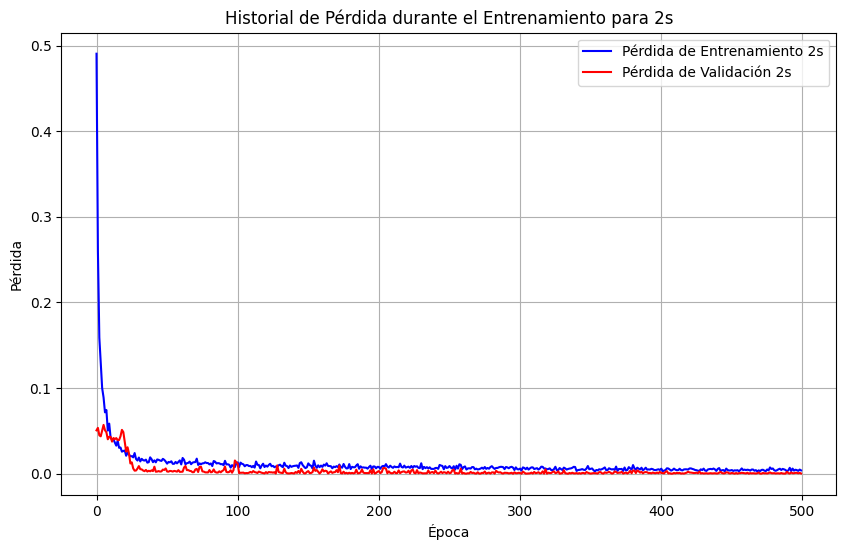

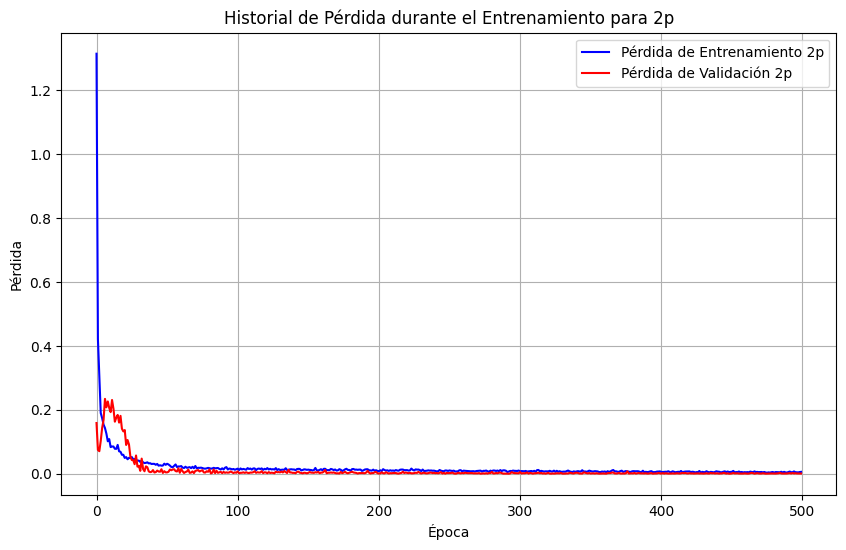

32/32 [==============================] - 0s 2ms/step


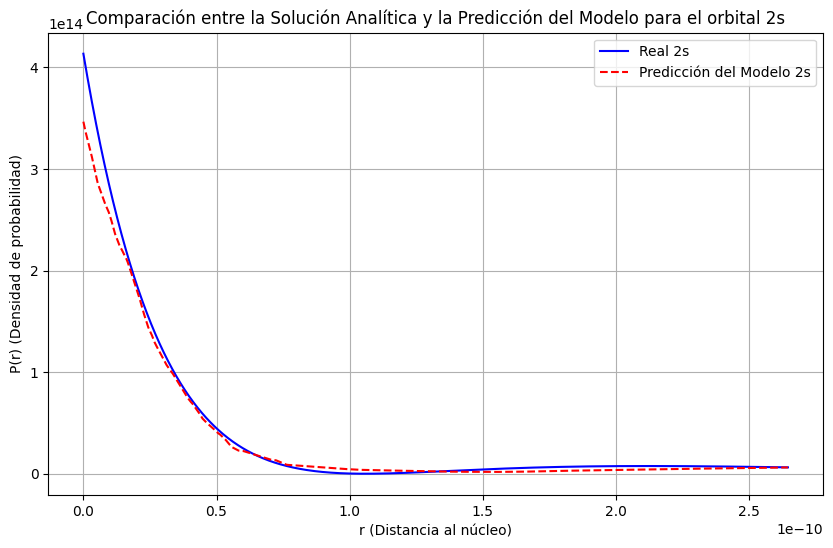

32/32 [==============================] - 0s 2ms/step


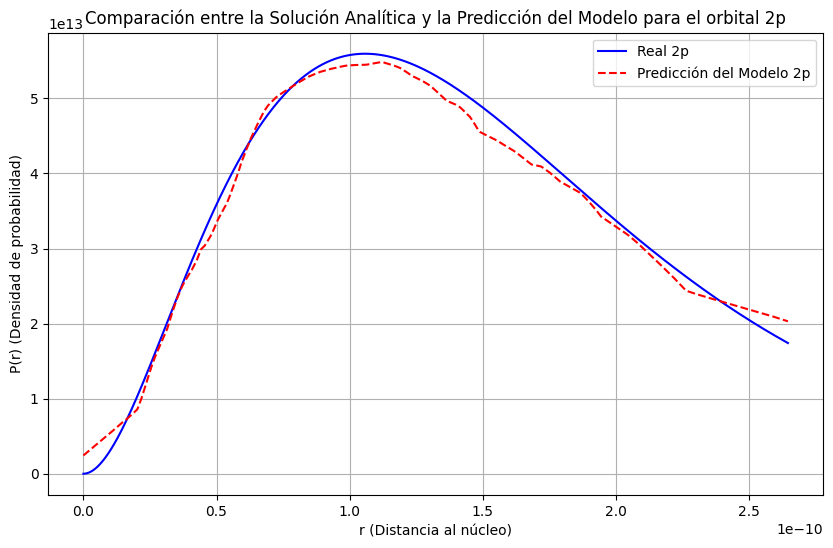

In [29]:
# 1. Visualizar el historial de pérdida durante el entrenamiento para los modelos 2s y 2p

# Para el modelo 2s
plt.figure(figsize=(10, 6))
plt.plot(history_P_2s.history['loss'], label='Pérdida de Entrenamiento 2s', color='blue')
plt.plot(history_P_2s.history['val_loss'], label='Pérdida de Validación 2s', color='red')
plt.title('Historial de Pérdida durante el Entrenamiento para 2s')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)
plt.show()

# Para el modelo 2p
plt.figure(figsize=(10, 6))
plt.plot(history_P_2p.history['loss'], label='Pérdida de Entrenamiento 2p', color='blue')
plt.plot(history_P_2p.history['val_loss'], label='Pérdida de Validación 2p', color='red')
plt.title('Historial de Pérdida durante el Entrenamiento para 2p')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)
plt.show()

# 2. Comparar las predicciones de los modelos con los datos reales para ambos orbitales

# Predicciones con el modelo 2s
P_2s_pred_scaled = model_P_2s.predict(scaler_r.transform(r_values.reshape(-1, 1)))
P_2s_pred = scaler_P_2s.inverse_transform(P_2s_pred_scaled)

plt.figure(figsize=(10, 6))
plt.plot(r_values, P_2s_values, label="Real 2s", color="blue")
plt.plot(r_values, P_2s_pred, label="Predicción del Modelo 2s", linestyle='--', color="red")
plt.xlabel("r (Distancia al núcleo)")
plt.ylabel("P(r) (Densidad de probabilidad)")
plt.title("Comparación entre la Solución Analítica y la Predicción del Modelo para el orbital 2s")
plt.legend()
plt.grid(True)
plt.show()

# Predicciones con el modelo 2p
P_2p_pred_scaled = model_P_2p.predict(scaler_r.transform(r_values.reshape(-1, 1)))
P_2p_pred = scaler_P_2p.inverse_transform(P_2p_pred_scaled)

plt.figure(figsize=(10, 6))
plt.plot(r_values, P_2p_values, label="Real 2p", color="blue")
plt.plot(r_values, P_2p_pred, label="Predicción del Modelo 2p", linestyle='--', color="red")
plt.xlabel("r (Distancia al núcleo)")
plt.ylabel("P(r) (Densidad de probabilidad)")
plt.title("Comparación entre la Solución Analítica y la Predicción del Modelo para el orbital 2p")
plt.legend()
plt.grid(True)
plt.show()
